In [1]:
import numpy as np
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from collections import defaultdict

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
# step backward feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [3]:
df_train = pd.read_csv('data/train.csv')
df_val = pd.read_csv('data/test.csv')

print(df_train.shape)
print(df_val.shape)

(137, 43)
(100000, 42)


### 1. PREPROC + EDA

In [4]:
df_train.head(5)

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


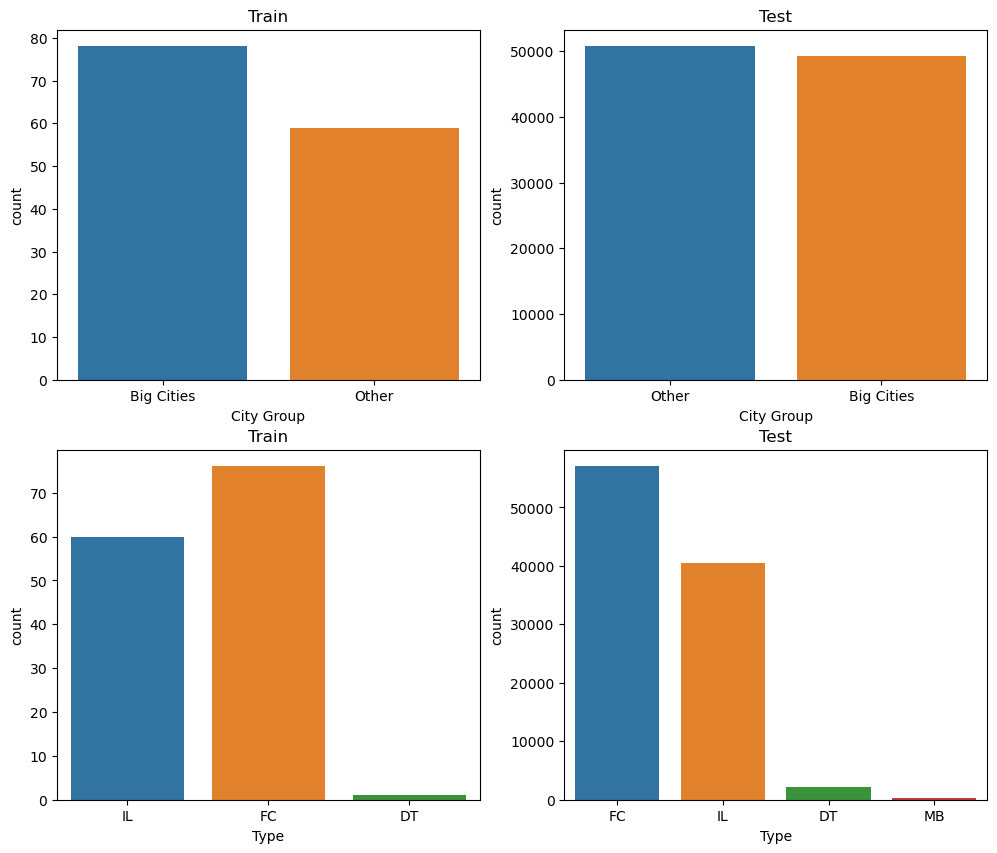

In [5]:
f, axes = plt.subplots(2, 2, figsize=(12,10))
sns.countplot(x='City Group', data=df_train, ax=axes[0, 0])
sns.countplot(x='City Group', data=df_val, ax=axes[0, 1])
axes[0, 0].set_title('Train')
axes[0, 1].set_title('Test')

sns.countplot(x='Type', data=df_train, ax=axes[1, 0])
sns.countplot(x='Type', data=df_val, ax=axes[1, 1])
axes[1, 0].set_title('Train')
axes[1, 1].set_title('Test')

plt.show()

In [6]:
#So, there is a new type 'MB' in test data and there is only one restaurant with DT type in the train dataset.

<AxesSubplot:xlabel='Type', ylabel='revenue'>

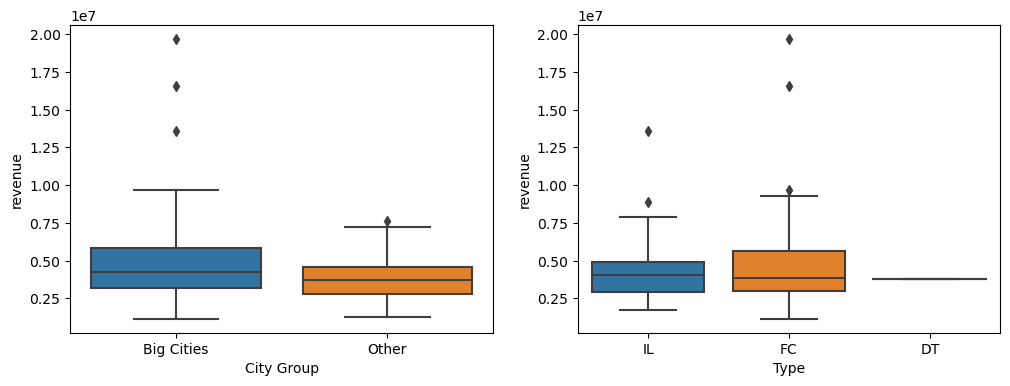

In [7]:
f, axes = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(data=df_train, x="City Group", y="revenue", ax=axes[0])
sns.boxplot(data=df_train, x="Type", y="revenue", ax=axes[1])

<AxesSubplot:xlabel='Type', ylabel='revenue'>

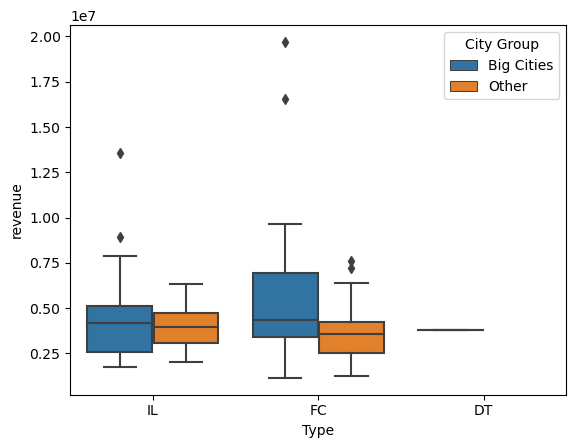

In [8]:
#f, axes = plt.subplots(1, 2, figsize=(12,4))
#sns.boxplot(data=df_train, x="City Group", y="revenue", ax=axes[0])
sns.boxplot(data=df_train, x="Type", y="revenue", hue="City Group")

In [9]:
### add a function for counting open days for each restaurant
own_date = date(2015, 1, 1) ### This competition ended in 2015 
def transform_date(df, new_date):
    df[['Open Date']] = df[['Open Date']].apply(pd.to_datetime)
    df['open_days'] = (pd.Timestamp(new_date) - df['Open Date']).dt.days
    df.drop(['Open Date'], axis=1, inplace=True)
    return df

In [10]:
df_train = transform_date(df_train, own_date)
df_val = transform_date(df_val, own_date)

In [11]:
### I don't know anything about P columns, so I want to check them in both datasets
P_cols = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 
          'P12', 'P13', 'P14', 'P15', 'P16','P17', 'P18', 'P19', 'P20', 'P21',
          'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 
          'P32', 'P33', 'P34', 'P35', 'P36', 'P37']

In [12]:
### save results in .pdf file 
plt.style.use('seaborn')
pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")

C:\Users\Me\AppData\Local\Temp\ipykernel_20508\3172890333.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 4, figsize=(18,5))


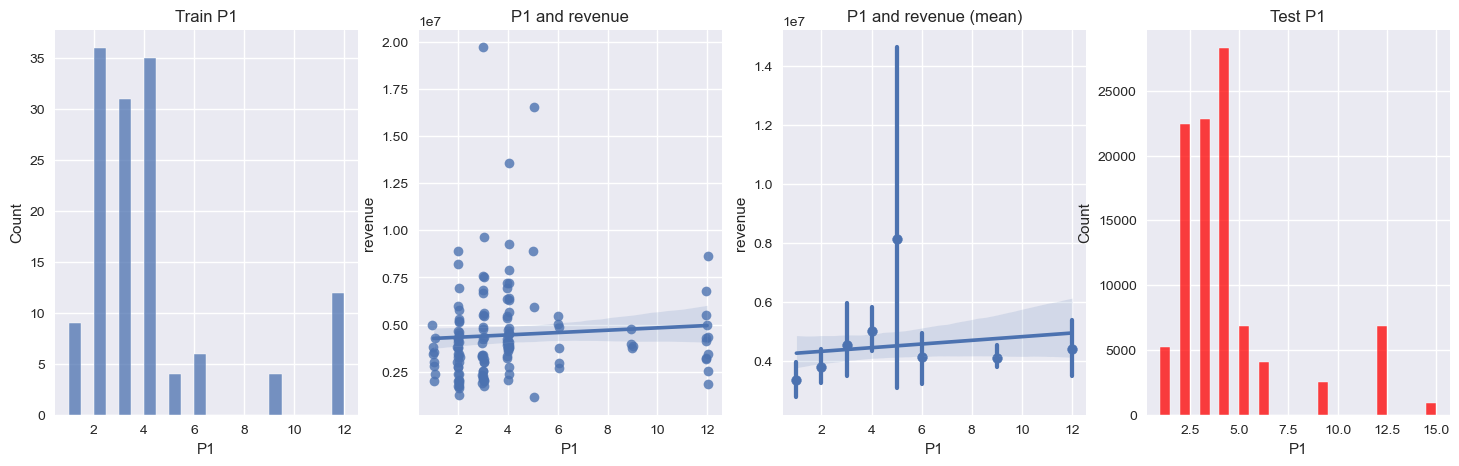

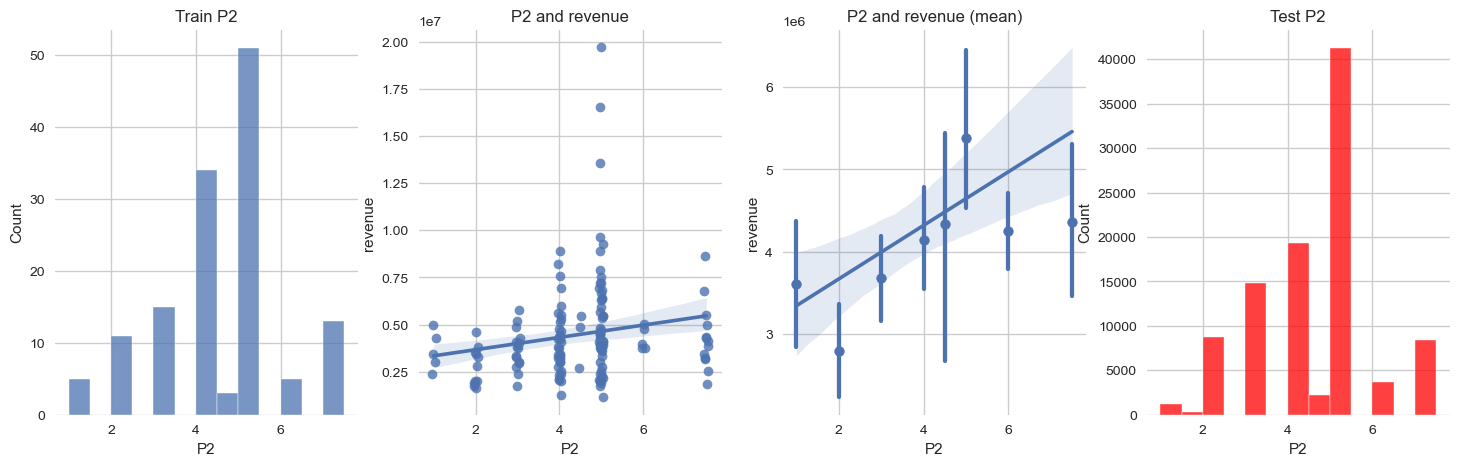

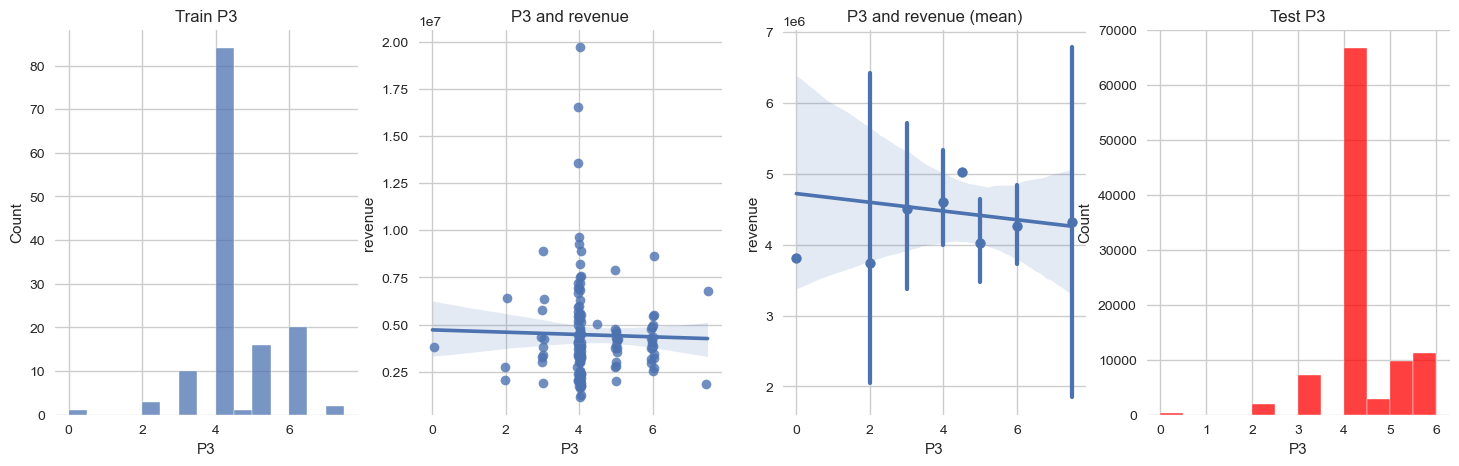

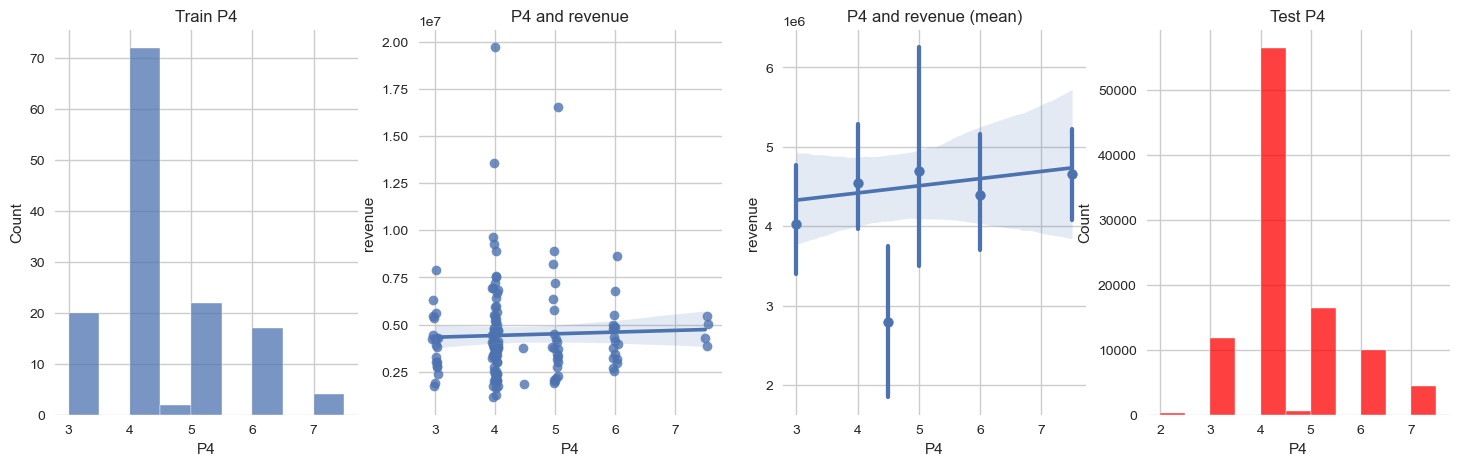

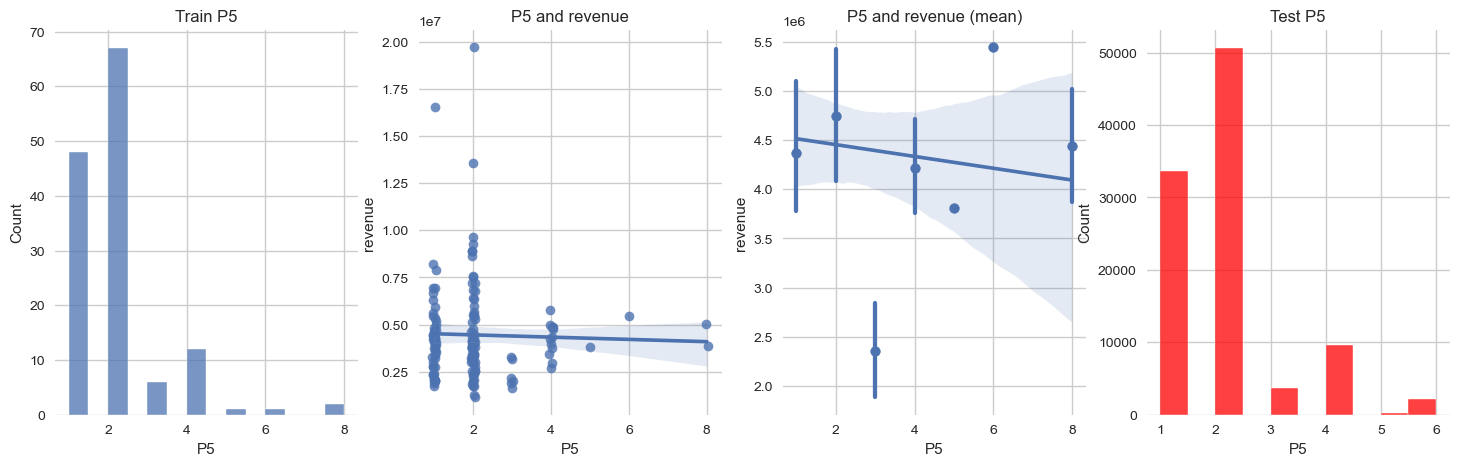

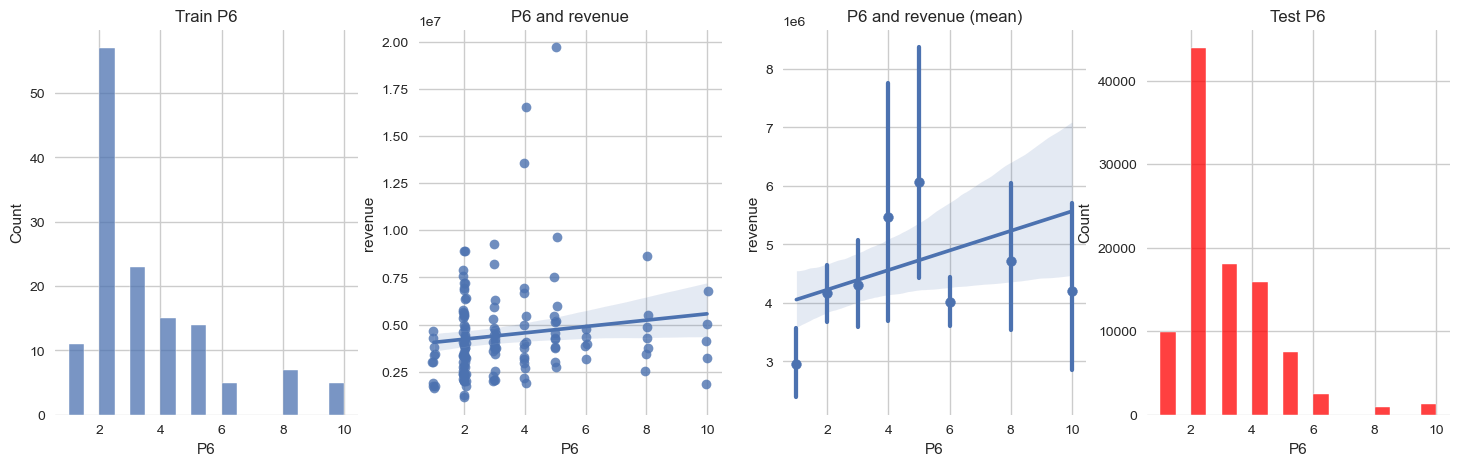

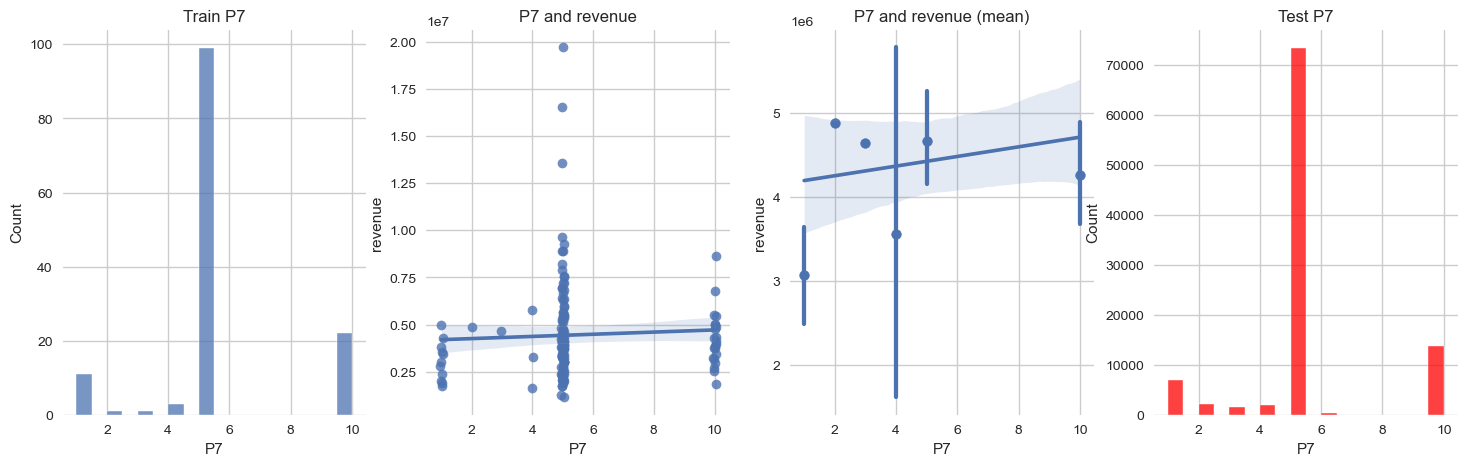

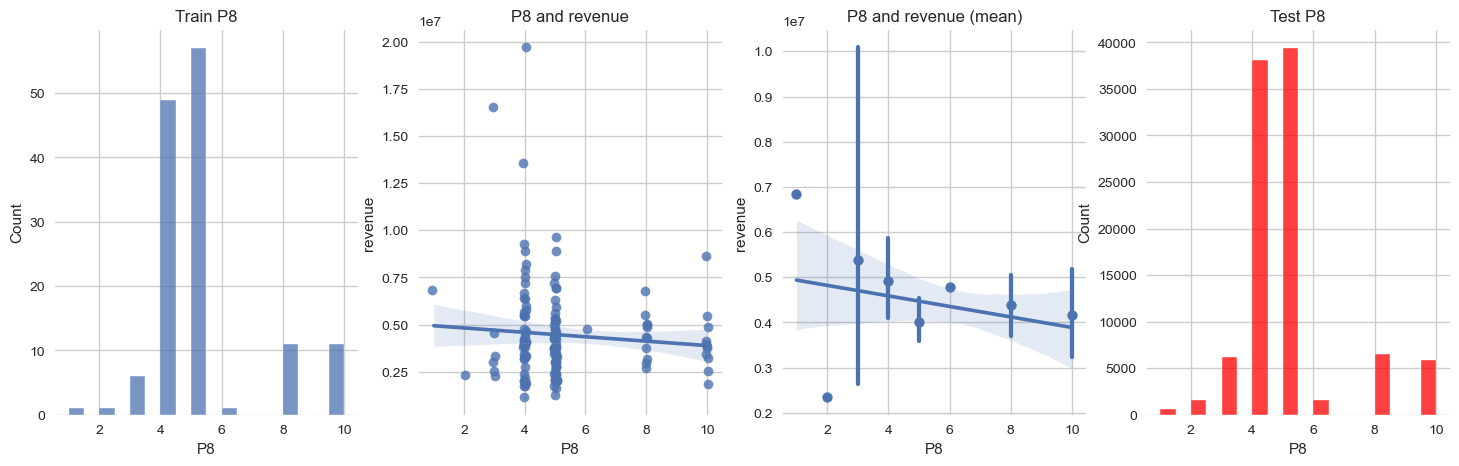

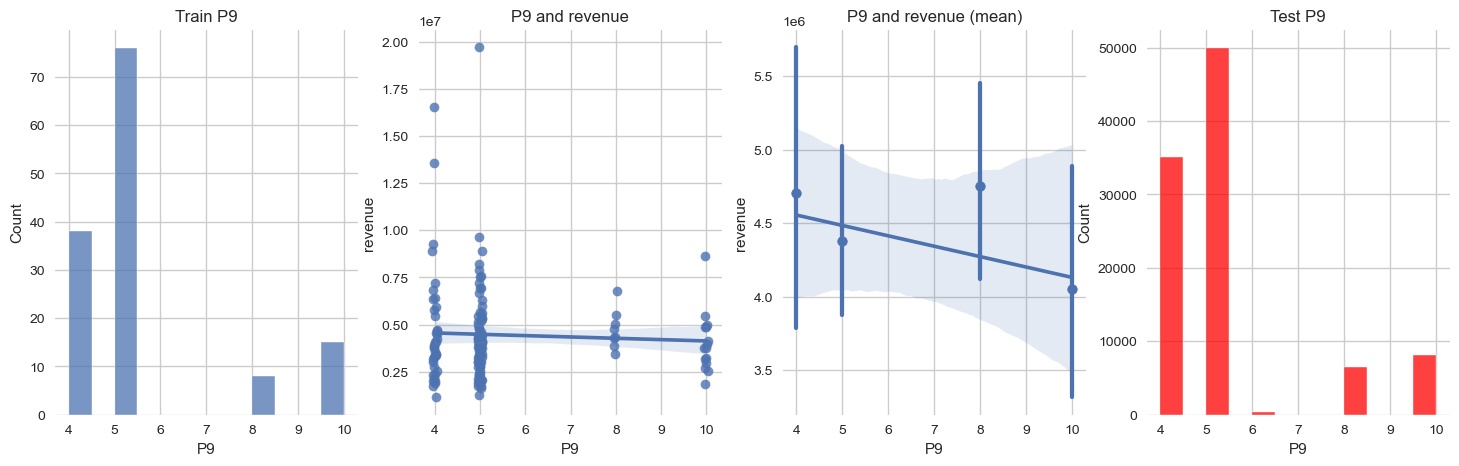

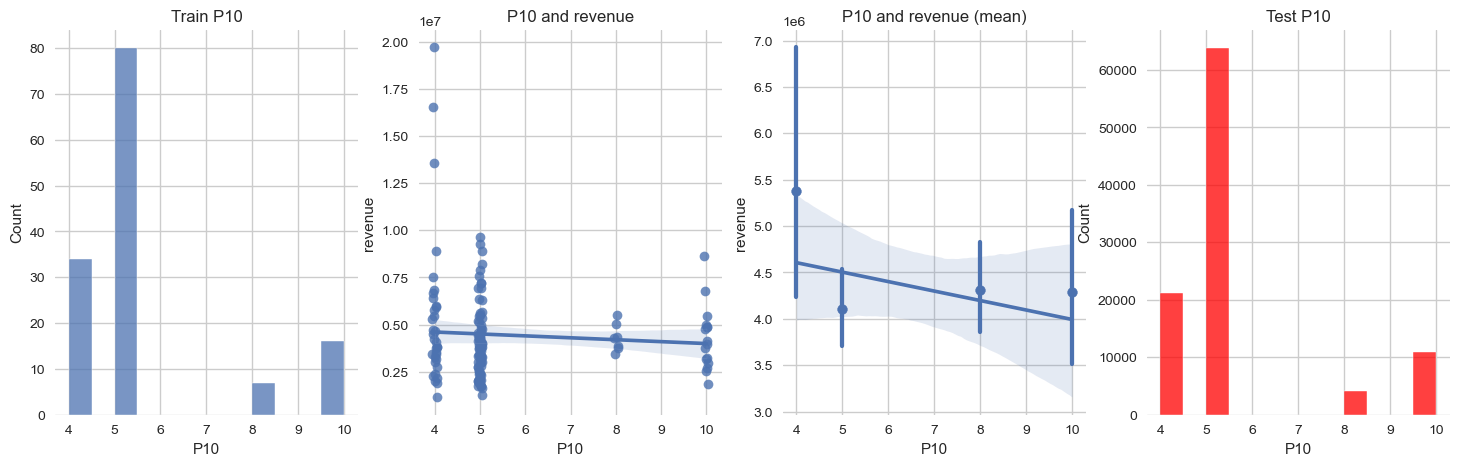

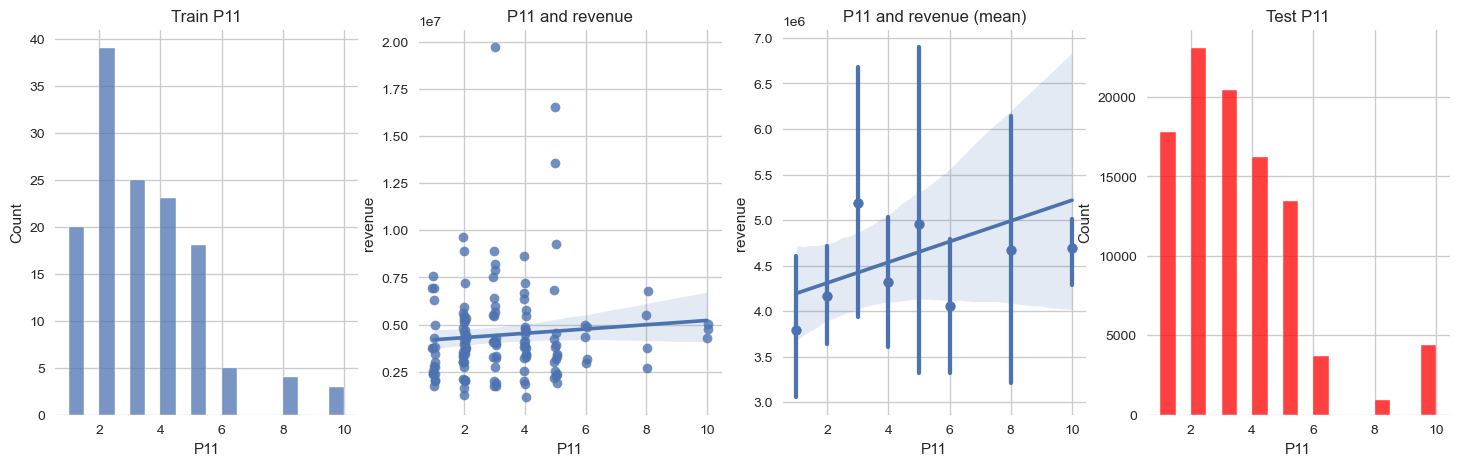

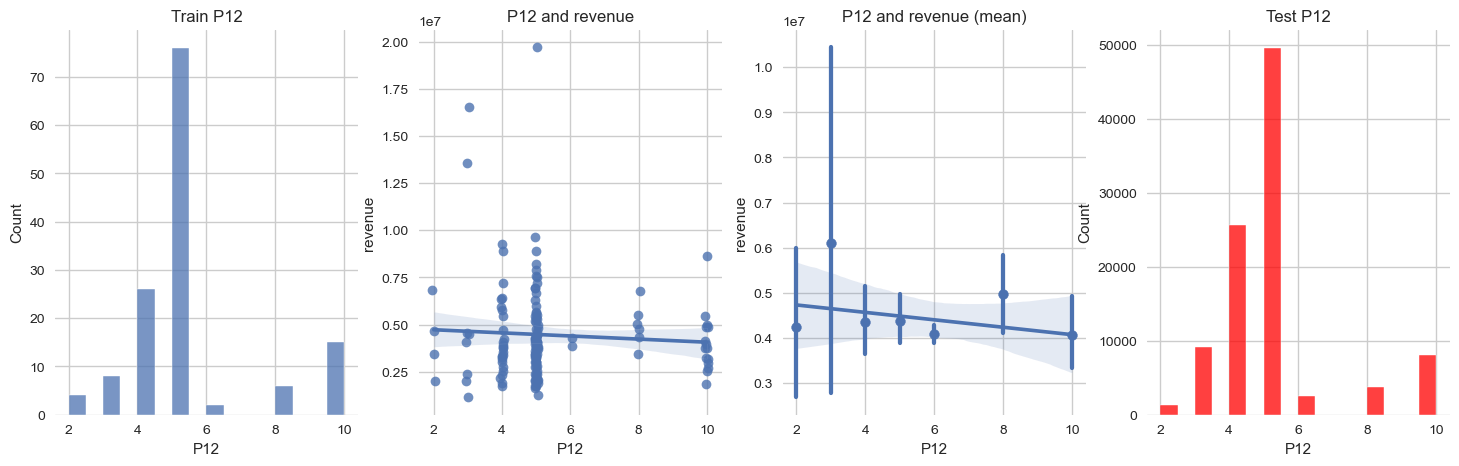

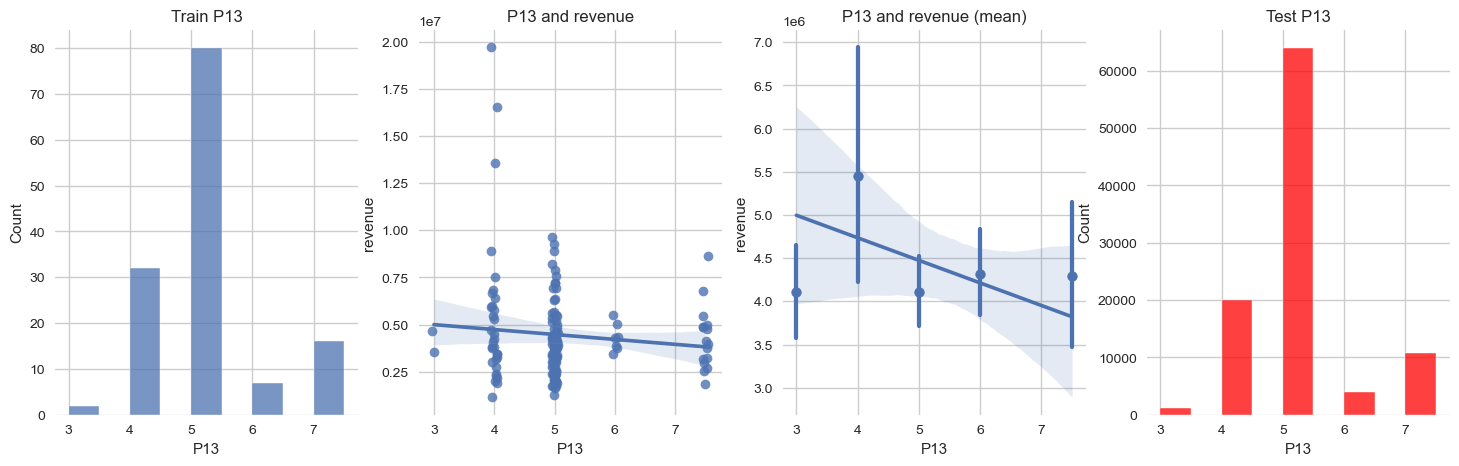

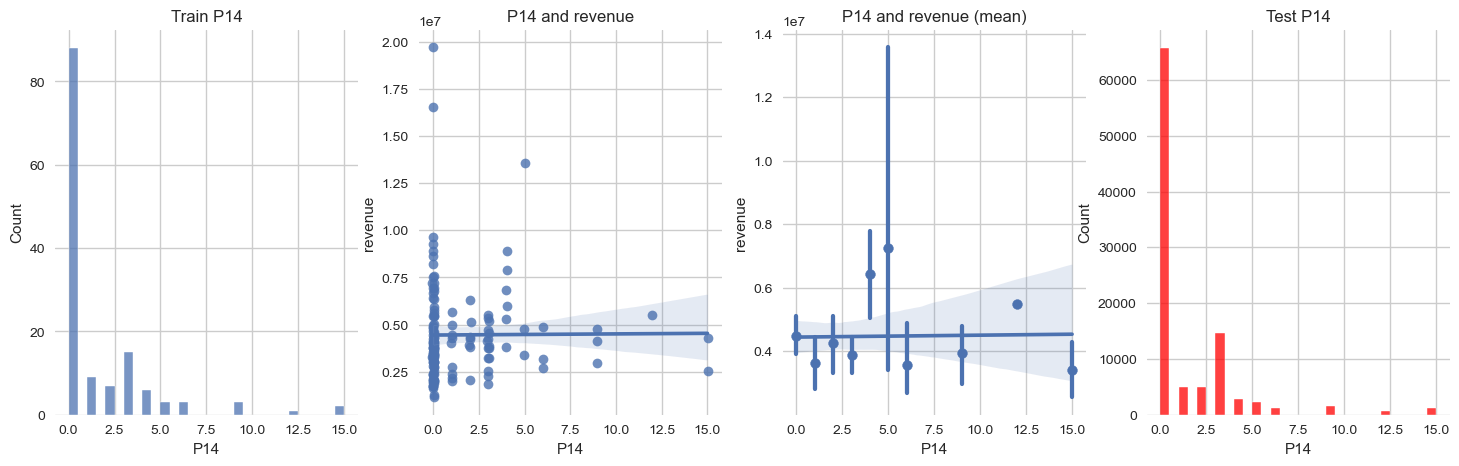

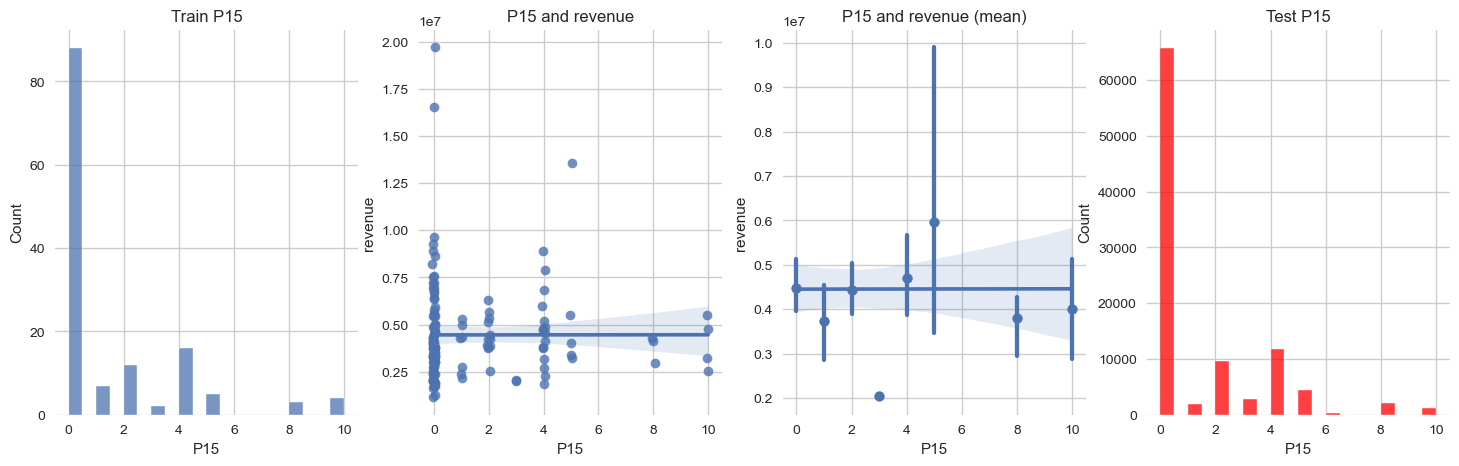

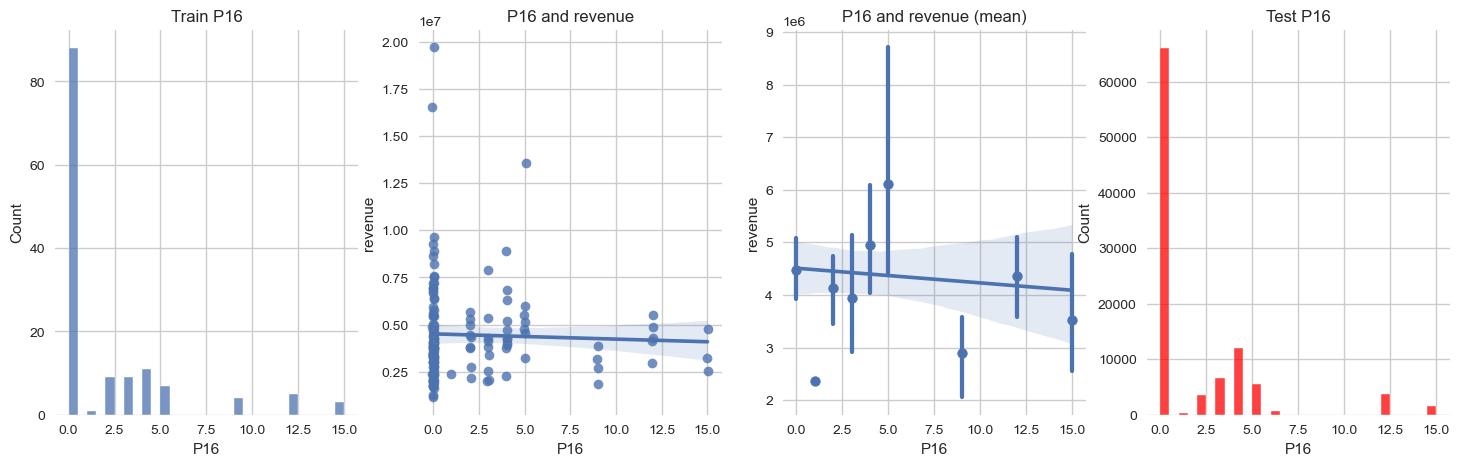

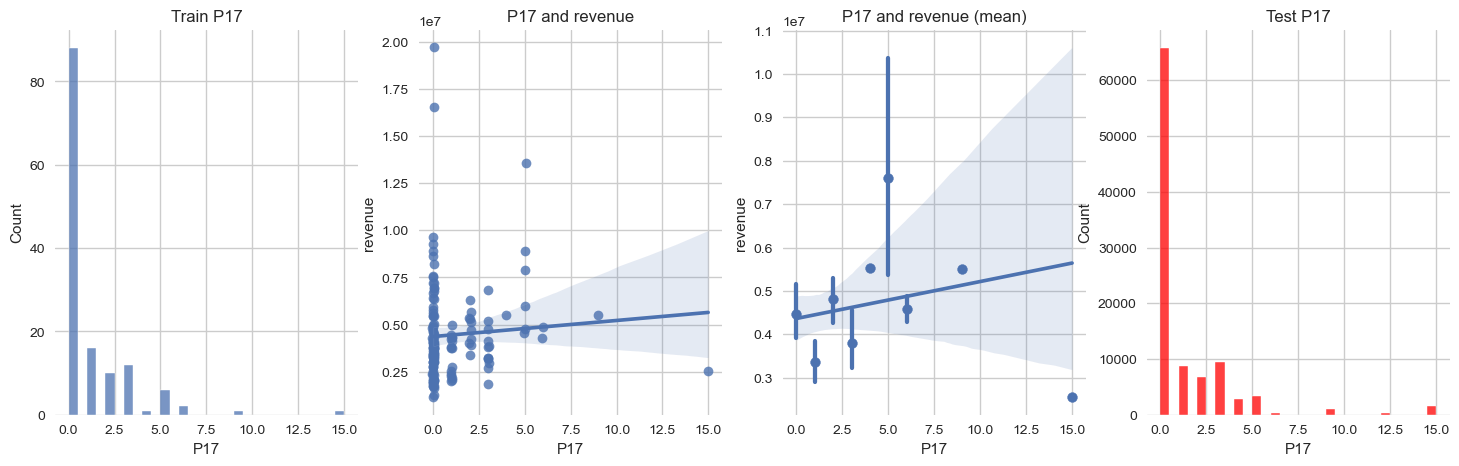

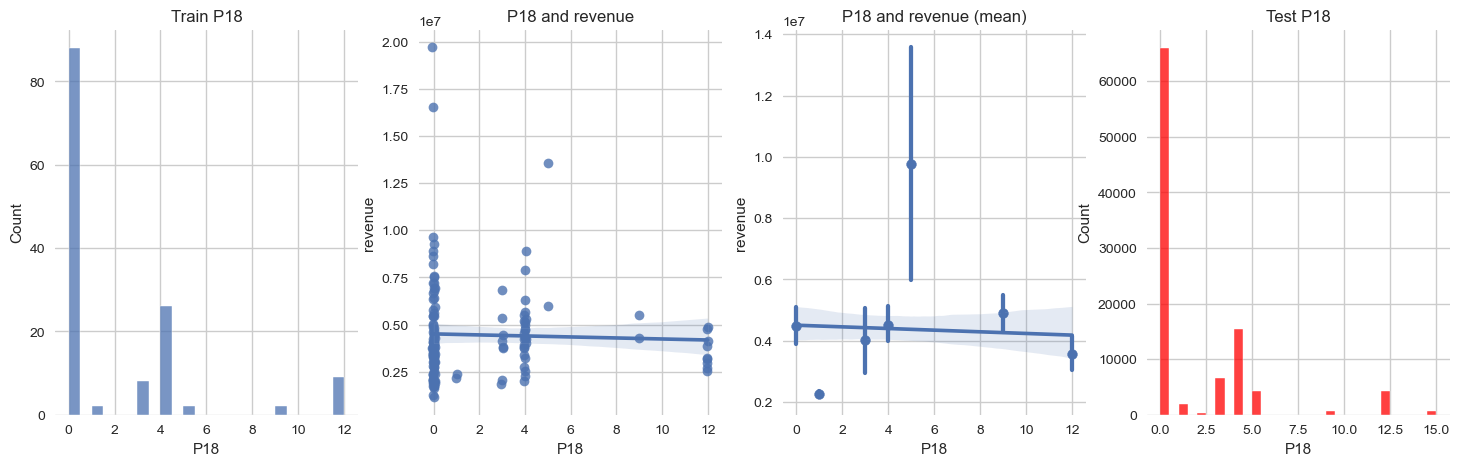

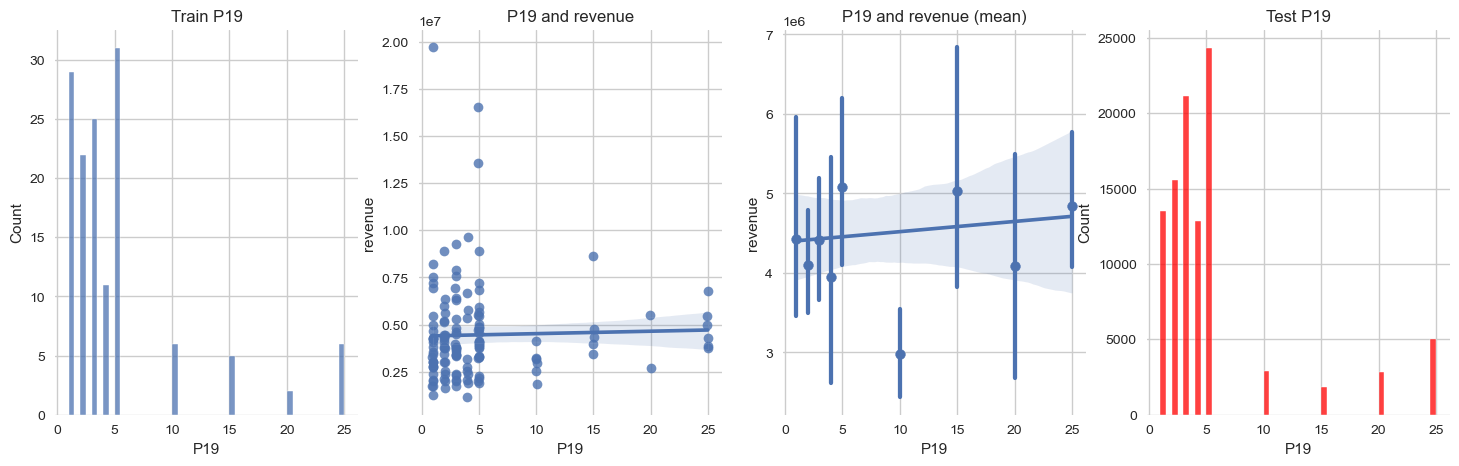

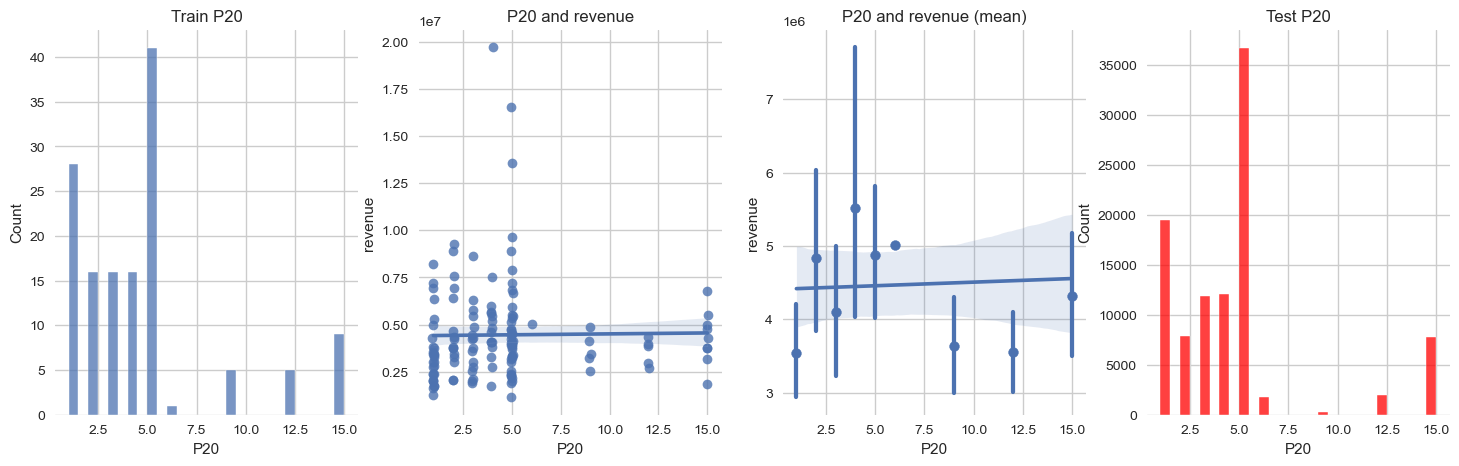

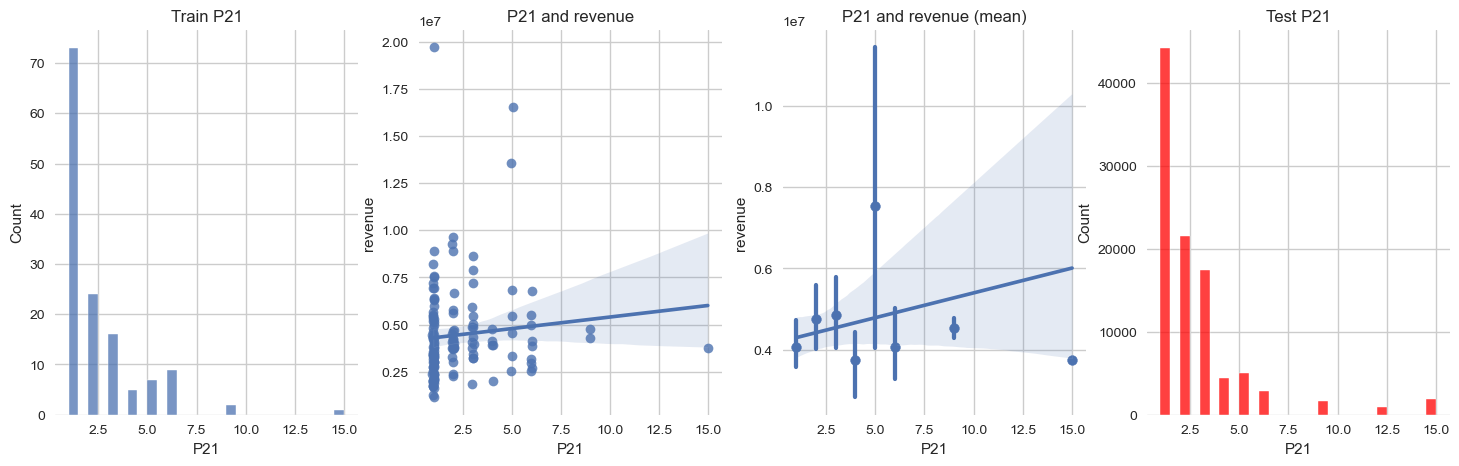

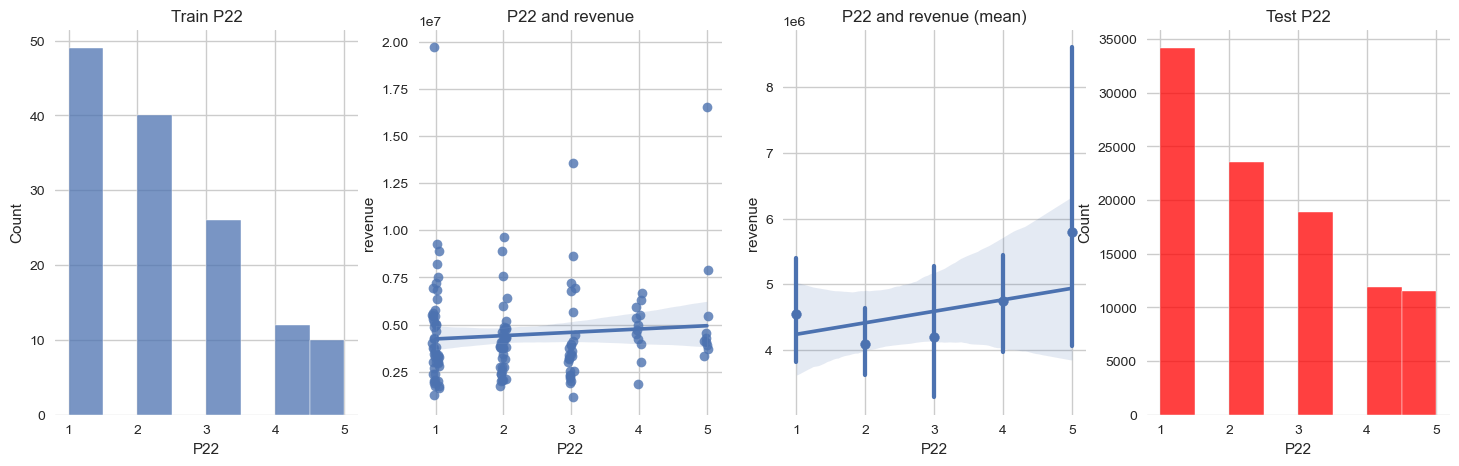

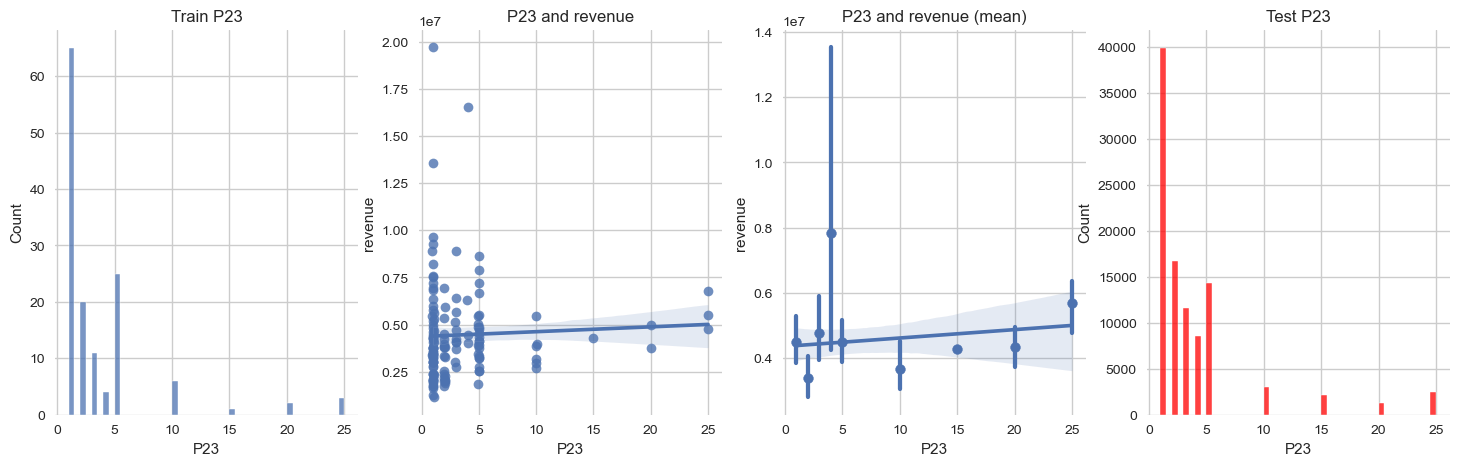

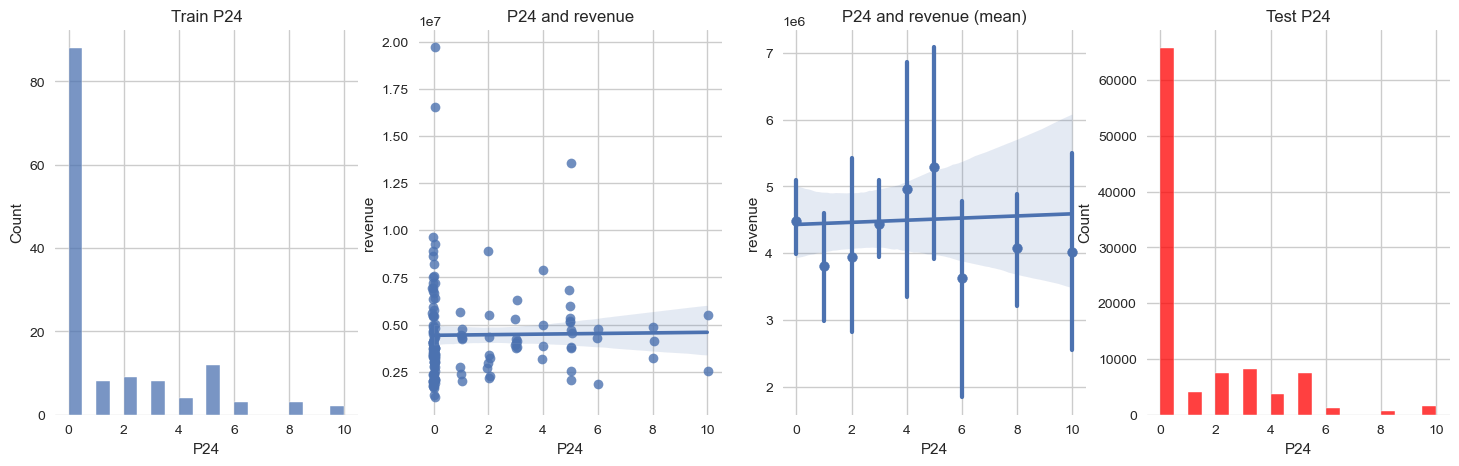

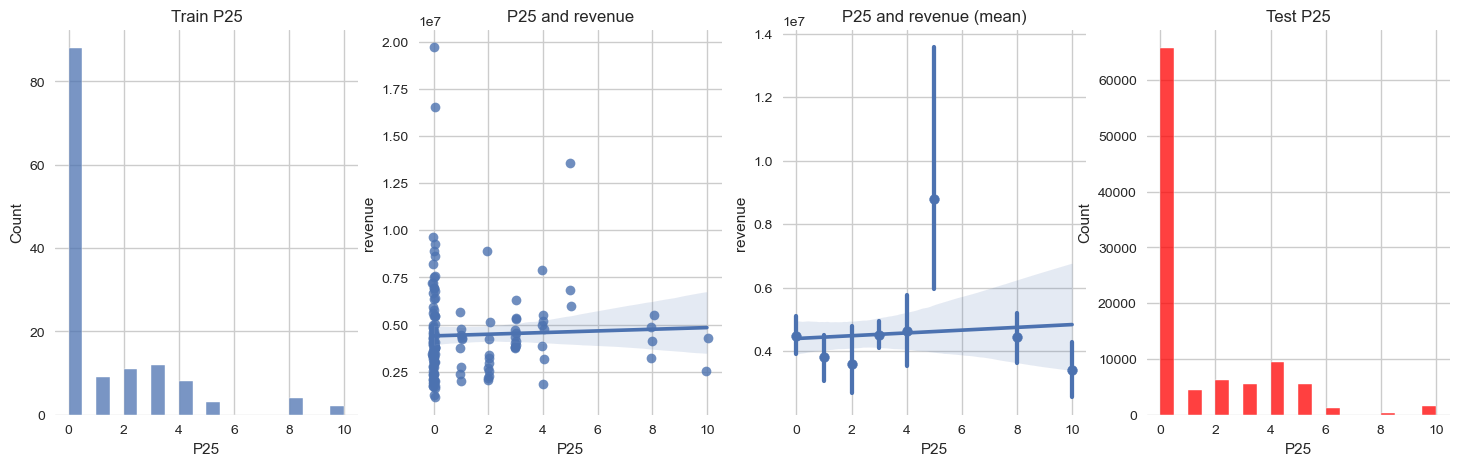

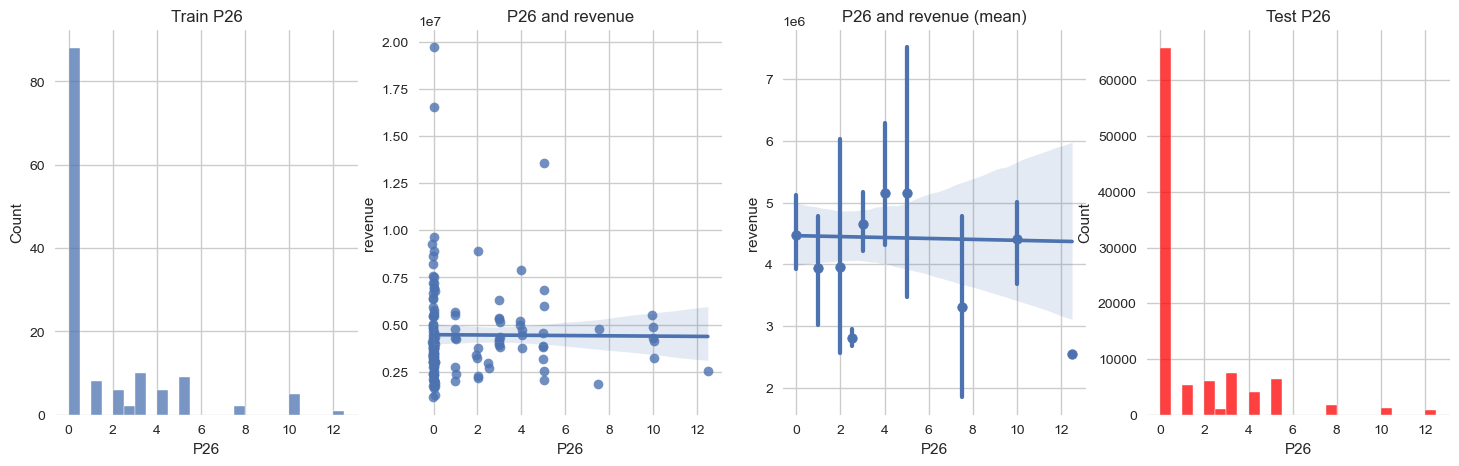

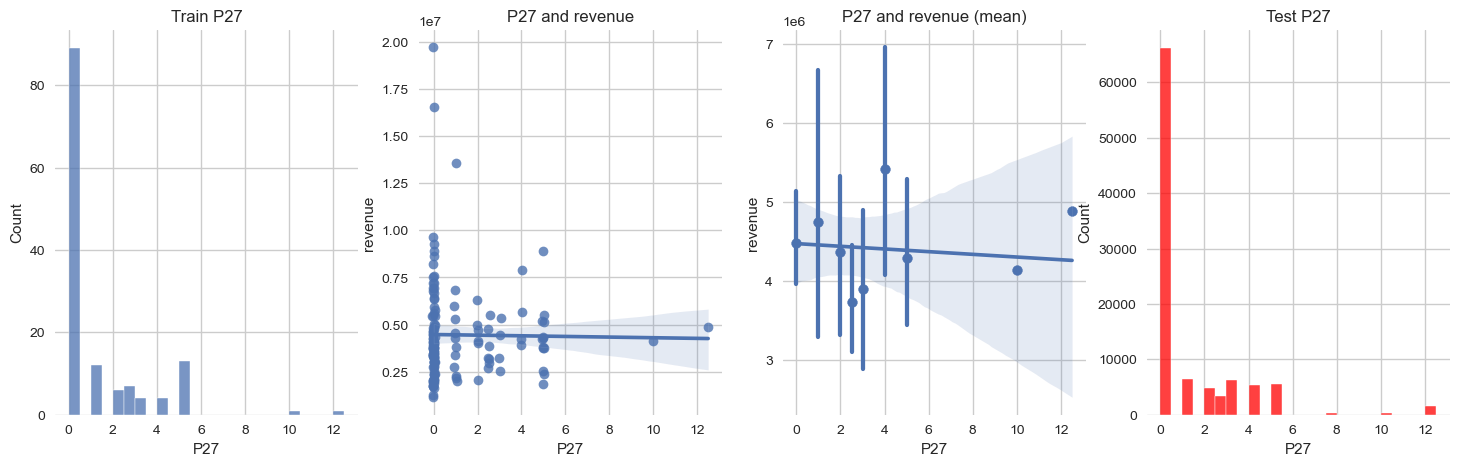

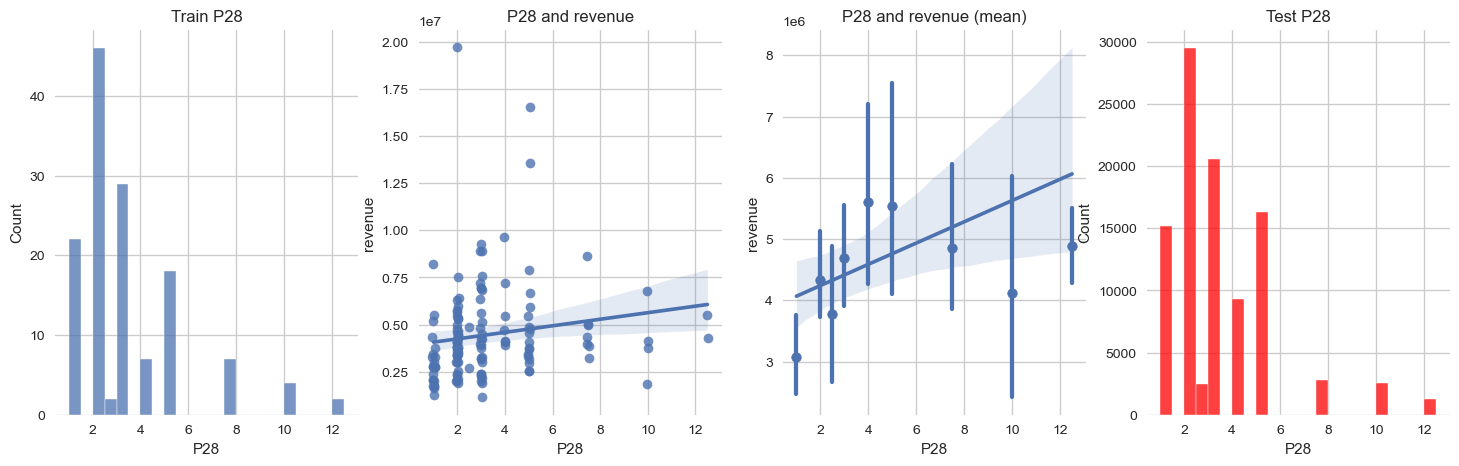

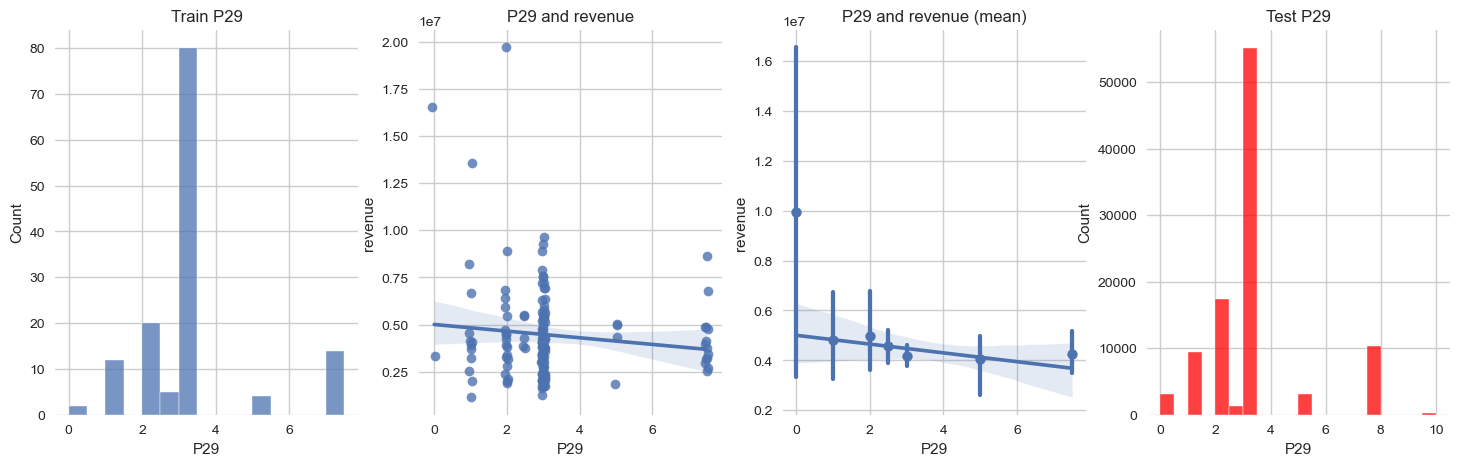

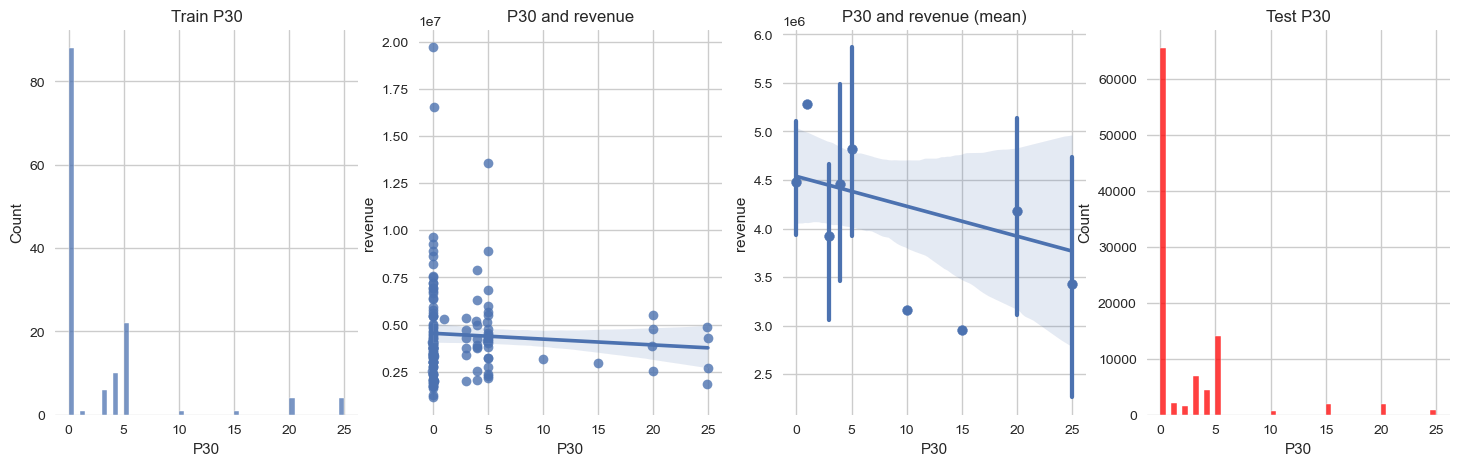

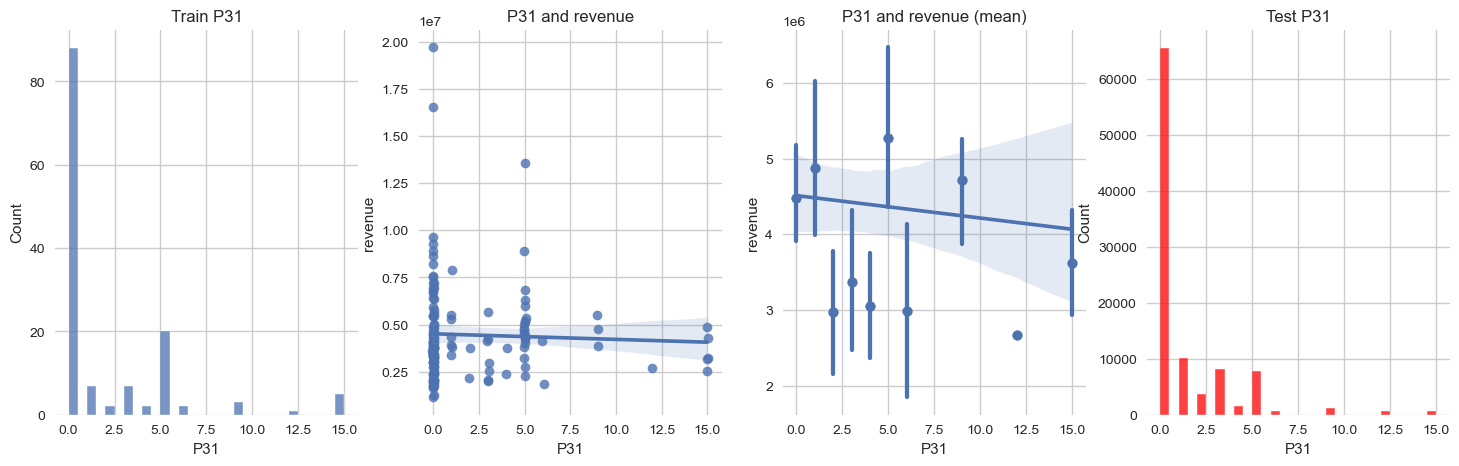

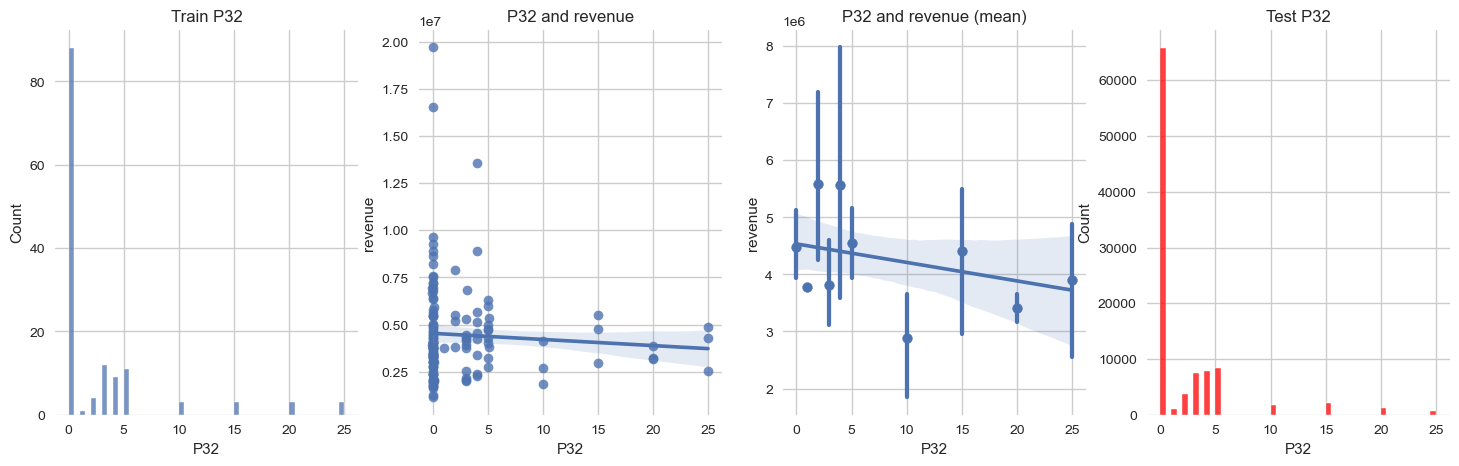

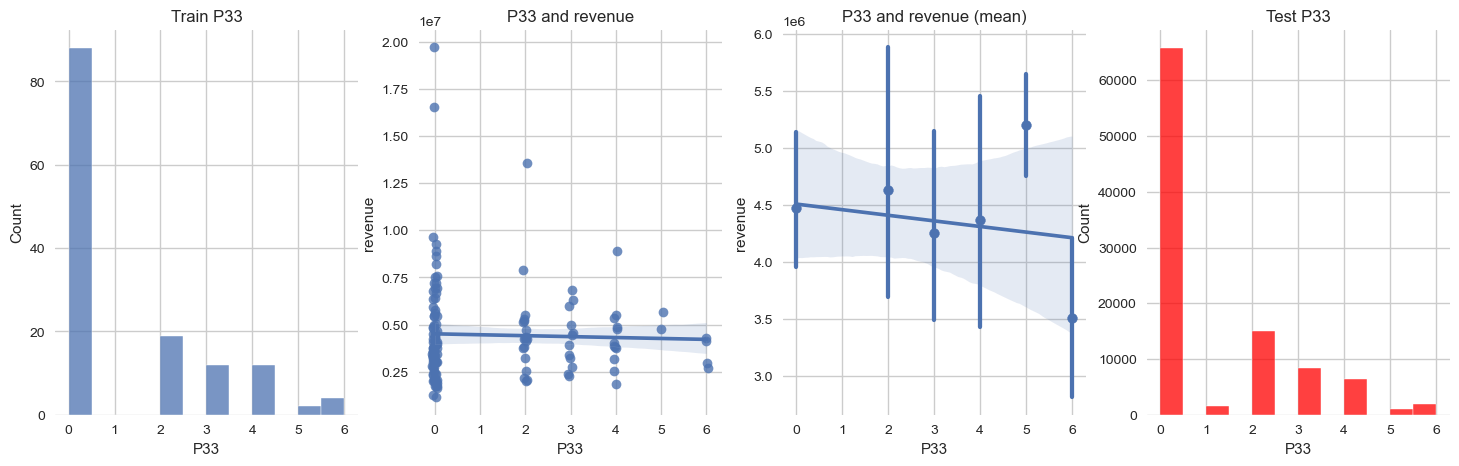

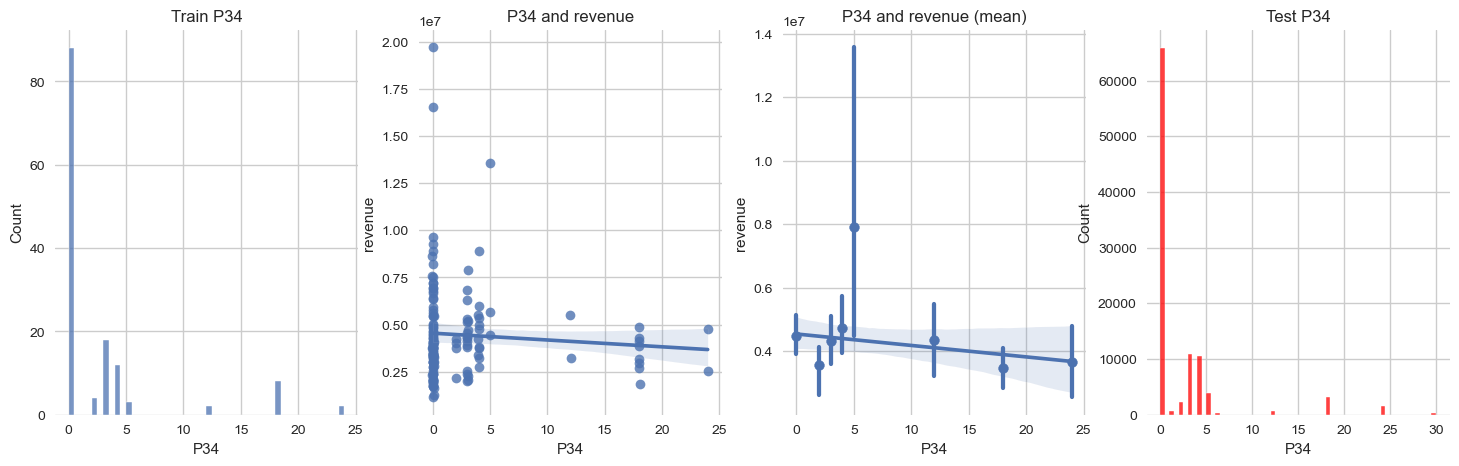

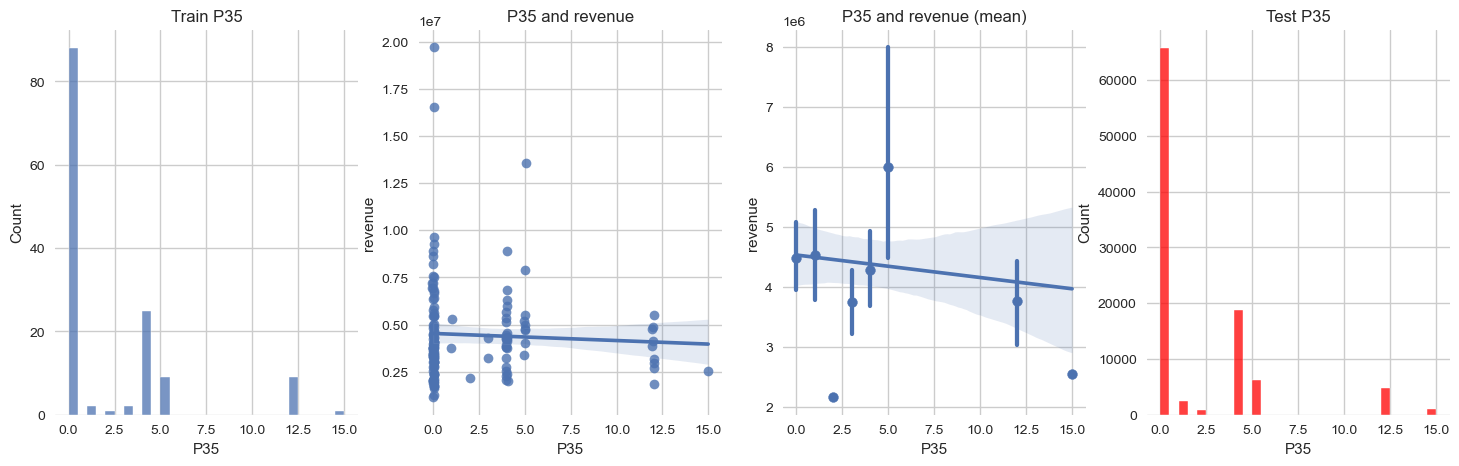

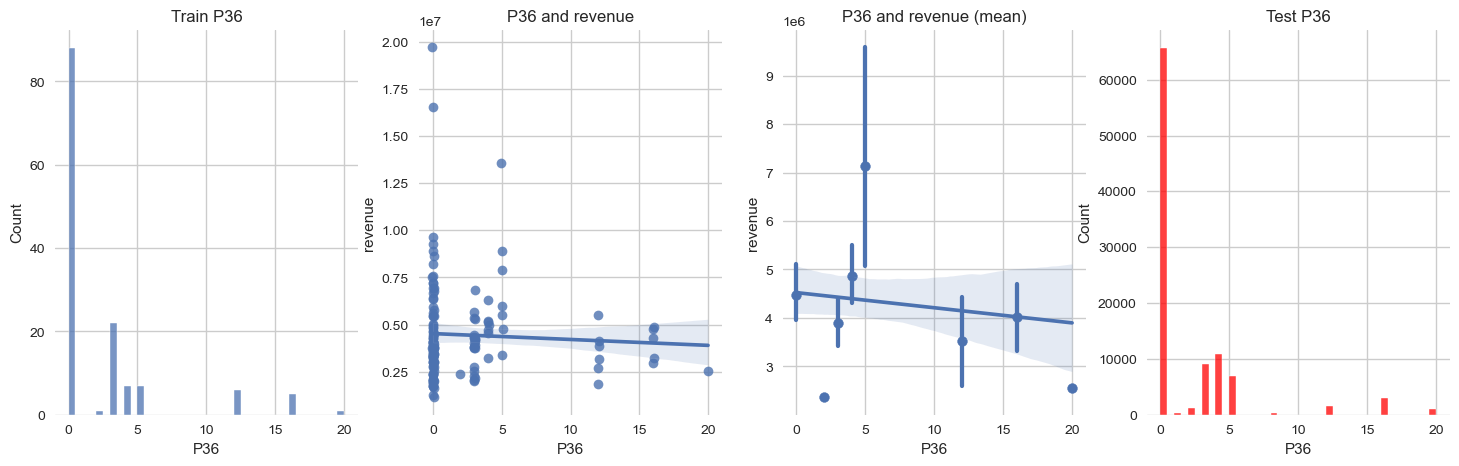

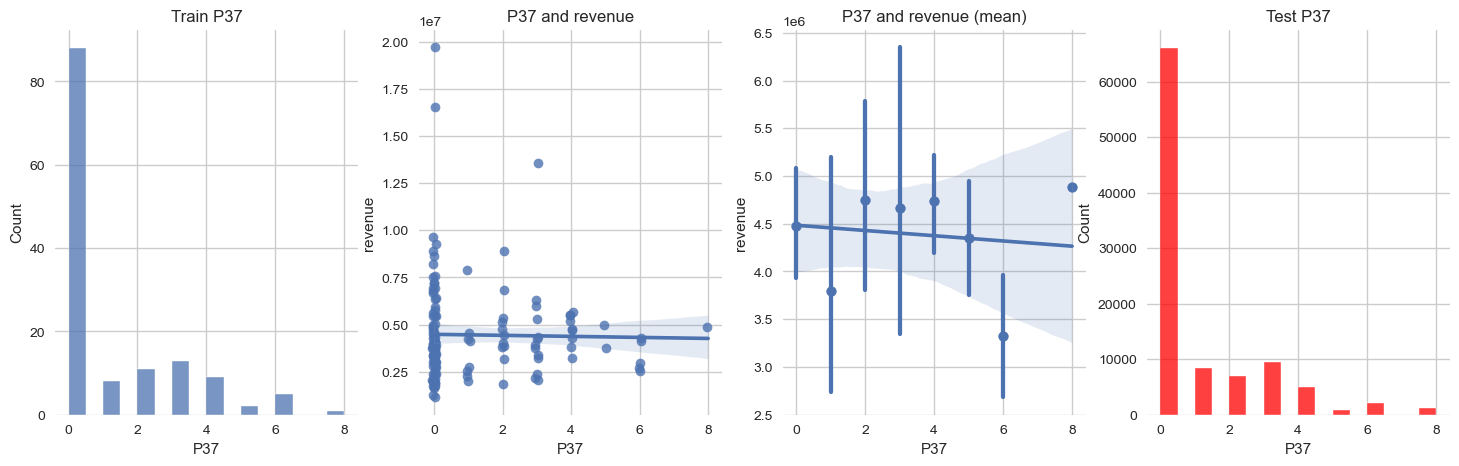

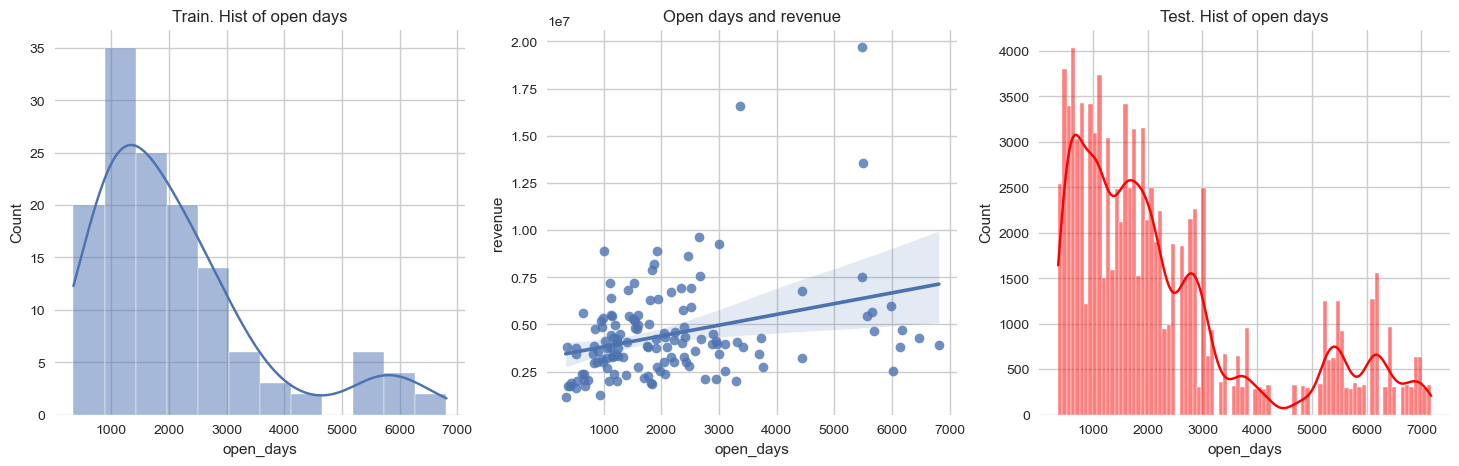

In [13]:
for p_col in P_cols:
 #   plt.figure()
    fig, axes = plt.subplots(1, 4, figsize=(18,5))
    sns.set_style("whitegrid")
    sns.histplot(df_train[p_col], binwidth = 0.5, ax=axes[0])
    sns.regplot(x=df_train[p_col], y=df_train.revenue, x_jitter=.05, ax=axes[1])
    sns.regplot(x=df_train[p_col], y=df_train.revenue, x_estimator=np.mean, ax=axes[2])
    sns.histplot(df_val[p_col], ax=axes[3], binwidth = 0.5, color='red')
    

    axes[0].set_title(f'Train {p_col}')
    axes[1].set_title(f'{p_col} and revenue')
    axes[2].set_title(f'{p_col} and revenue (mean)')
    axes[3].set_title(f'Test {p_col}' )
    pdf.savefig( fig )
    
### Open days and revenue
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.set_style("whitegrid")
sns.histplot(df_train['open_days'], kde=True, ax=axes[0])
sns.regplot(x=df_train['open_days'], y=df_train.revenue, ax=axes[1])
sns.histplot(df_val['open_days'], kde=True, ax=axes[2], color='red')

axes[0].set_title(f'Train. Hist of open days')
axes[1].set_title(f'Open days and revenue')
axes[2].set_title(f'Test. Hist of open days')
pdf.savefig( fig )

### close file
pdf.close()    

In [ ]:
##df_train_remove = df_train[df_train.revenue <= 10000000]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(labels=['Id', 'open_days', 'revenue'], axis=1),  # drop the target
    df_train['revenue'],  # just the target
    test_size=0.1,
    random_state=0)

X_train.shape, X_test.shape

((123, 40), (14, 40))

Unfortunately, the LabelEncoder works one variable at the time. However there is a way to automate this for all the categorical variables.

### 2. Categorical features encoding + target scaling

#### OrdinalEncoder
Encode categorical features as an integer array.

The input to this transformer should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. The features are converted to ordinal integers. This results in a single column of integers (0 to n_categories - 1) per feature.

In [16]:
from sklearn.preprocessing import OrdinalEncoder

In [17]:
ord_e = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.NaN)

In [18]:
cat_cols_label_enc = ['City', 'City Group', 'Type',]

In [19]:
X_train_transform = ord_e.fit_transform(X_train[cat_cols_label_enc])
X_train_transform = pd.DataFrame(X_train_transform)

In [32]:
X_test_transform = pd.DataFrame.from_records(ord_e.transform(X_test[cat_cols_label_enc]))
X_test_transform = X_test_transform.apply(lambda column: column.replace(np.NaN, max(column)+1), axis=0)

In [38]:
df_val_transform = pd.DataFrame.from_records(ord_e.transform(df_val[cat_cols_label_enc]))
df_val_transform = df_val_transform.apply(lambda column: column.replace(np.NaN, 100), axis=0)

In [40]:
X_train_transform.columns = cat_cols_label_enc
X_test_transform.columns = cat_cols_label_enc
df_val_transform.columns = cat_cols_label_enc

#### Target scaling, MinMax(0,1)

In [41]:
target_scaler = MinMaxScaler(feature_range = (0,1))
target_scaler.fit(y_train.values.reshape(-1, 1))

MinMaxScaler()

In [42]:
y_train_scale = target_scaler.transform(y_train.values.reshape(-1, 1))

In [74]:
X_train_all = pd.concat([X_train_transform, X_train.iloc[:, 3:].reset_index(drop=True)], axis=1)
X_test_all = pd.concat([X_test_transform, X_test.iloc[:, 3:].reset_index(drop=True)], axis=1)
df_val_all = pd.concat([df_val_transform, df_val.iloc[:, 4:].reset_index(drop=True)], axis=1)

### Feature selection + KNN regression 

I work with all features like they are categorical. I want to use KNN regression and hamming distance to predict the revenue. 
Hamming distance is a metric for comparing two data strings. While comparing two strings of equal length, Hamming distance is the number of positions in which the data are different

So, the main questions here - are whether all features are useful for prediction and how many neighbors should be chosen.

In [61]:
sfs = SFS(KNeighborsRegressor(metric = 'hamming',n_neighbors=1),
          k_features=2, # the lower the features we want, the longer this will take
          forward=False,
          cv=20,
          verbose=0,
          scoring='r2')

sfs = sfs.fit(np.array(X_train_all), y_train_scale)
df_k = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
df_k['k'] = 1
frames = [df_k]
df_k_all = pd.concat(frames)

In [62]:
for k in range(2, 15):
    sfs = SFS(KNeighborsRegressor(metric = 'hamming',n_neighbors=k),
          k_features=2, # the lower the features we want, the longer this will take
          forward=False,
          cv=20,
          verbose=0,
          scoring='r2')

    sfs = sfs.fit(np.array(X_train_all), y_train_scale)
    df_k = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
    df_k['k'] = k
    frames = [df_k_all, df_k]
    df_k_all = pd.concat(frames)
    print(k)

2
3
4
5
6
7
8
9
10
11
12
13
14


It's a little bit tricky part but it works well for me. I have a dramatically small data set for train and every sample is important (it was a reason not to delete outliers) so I wanted to choose a model with the greatest generalizability. I used std_err, which quantifies the variations in the means from multiple sets for the best hyperparameter (k neighbors) and features subset searching.

In [96]:
df_k_all.sort_values('std_err', ascending=True)[:10]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,k
27,"(2, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17,...","[0.2384585927928644, -0.26762507826280957, 0.2...",-0.304687,"(2, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17,...",0.200764,0.419523,0.096245,8
26,"(4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19...","[0.2396089993717535, -0.24217332558166094, 0.1...",-0.276159,"(4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19...",0.204058,0.426407,0.097824,8
24,"(4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 19, 20, 2...","[0.462856456427012, -0.2706117517421396, 0.239...",-0.195371,"(4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 19, 20, 2...",0.212148,0.443312,0.101703,8
25,"(4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 2...","[0.2396089993717535, -0.24610420055437476, 0.1...",-0.235493,"(4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17, 19, 2...",0.212816,0.444707,0.102023,8
16,"(4, 5, 6, 8, 10, 12, 15, 19, 20, 22, 24, 27, 3...","[-0.7056693788096202, -0.30579523449522417, 0....",-0.271005,"(4, 5, 6, 8, 10, 12, 15, 19, 20, 22, 24, 27, 3...",0.215631,0.45059,0.103373,7
14,"(5, 6, 8, 10, 12, 19, 20, 22, 24, 27, 30, 33, ...","[-0.5594902687674697, -0.3610211657436948, 0.1...",-0.357453,"(5, 6, 8, 10, 12, 19, 20, 22, 24, 27, 30, 33, ...",0.217648,0.454805,0.10434,7
12,"(5, 6, 8, 10, 12, 19, 20, 22, 24, 30, 33, 38)","[-0.33925341822780153, -0.35739582060796615, 0...",-0.349646,"(5, 6, 8, 10, 12, 19, 20, 22, 24, 30, 33, 38)",0.219403,0.458473,0.105181,7
13,"(5, 6, 8, 10, 12, 19, 20, 22, 24, 27, 30, 33, 38)","[-0.13162088341291156, -0.3578539054861207, 0....",-0.321078,"(5, 6, 8, 10, 12, 19, 20, 22, 24, 27, 30, 33, 38)",0.221864,0.463614,0.10636,7
24,"(0, 1, 3, 6, 8, 9, 10, 11, 13, 15, 19, 20, 22,...","[0.07676410411412982, -0.20057653348637694, 0....",-0.258354,"(0, 1, 3, 6, 8, 9, 10, 11, 13, 15, 19, 20, 22,...",0.225501,0.471214,0.108104,6
32,"(0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...","[-0.038061925563764865, -0.0864669729529648, 0...",-0.306144,"(0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...",0.227585,0.475569,0.109103,7


In [85]:
f_indexes = list(df_k_all.sort_values('std_err', ascending=True).iloc[0, 0])

In [86]:
colmns_selected = list(X_train_all.columns[f_indexes])

In [87]:
colmns_selected

['Type',
 'P2',
 'P3',
 'P4',
 'P6',
 'P7',
 'P8',
 'P9',
 'P10',
 'P12',
 'P13',
 'P14',
 'P15',
 'P17',
 'P18',
 'P20',
 'P21',
 'P22',
 'P23',
 'P25',
 'P26',
 'P27',
 'P28',
 'P31',
 'P34',
 'P36',
 'P37']

In [88]:
knn_reg = KNeighborsRegressor(metric = 'hamming',n_neighbors=8)
knn_reg.fit(X_train_all[colmns_selected], y_train_scale)
y_pred = knn_reg.predict(X_test_all[colmns_selected])
y_pred_scale = target_scaler.inverse_transform(y_pred.reshape(1,-1))[0]

In [89]:
mean_squared_error(y_test, y_pred_scale, squared=False)

1516719.2681006875

In [90]:
r2_score(y_test, y_pred_scale)

0.371030274821579

In [91]:
y_val = knn_reg.predict(df_val_all[colmns_selected])
y_val_scale = target_scaler.inverse_transform(y_val.reshape(1,-1))[0]

In [93]:
df_t = df_val[['Id']]
df_t.insert(1, "Prediction", y_val_scale.tolist(), True)
df_t.to_csv("knn.csv", index=False)

In [94]:
df_t.describe()
## Score: 1833848.89072
## Private score: 1963726.46929

,Id,Prediction
count,100000.000000,1.000000e+05
mean,49999.500000,4.530521e+06
std,28867.657797,1.024598e+06
min,0.000000,1.923331e+06
25%,24999.750000,3.787234e+06
50%,49999.500000,4.453552e+06
75%,74999.250000,5.209051e+06
max,99999.000000,9.798436e+06
